In [9]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split
import re
import albumentations as A # type: ignore
from albumentations.pytorch import ToTensorV2 # type: ignore
from pytesseract import Output
import easyocr

dataset_path = r'C:\Users\admin\OneDrive\Documents\GitHub\Test\Internship-Aimesoft-ALPR\ALPR\datasets'

def the_number_in_the_string(filename):
    match = re.search(r'(\d+)', filename)
    return int(match.group(0)) if match else 0


In [10]:
def correct_rotation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    if lines is not None:
        angles = [np.arctan2(line[0][1], line[0][0]) * 180 / np.pi for line in lines]
        angle = np.mean(angles)
        if angle < -45:
            angle += 90
        elif angle > 45:
            angle -= 90
        center = (image.shape[1] // 2, image.shape[0] // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC)
    return image

def enhance_brightness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)
    return cv2.merge([equalized, equalized, equalized])

def correct_perspective(image, points):
    width, height = 400, 200
    pts1 = np.float32(points)
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    return cv2.warpPerspective(image, matrix, (width, height))


In [11]:
def augment_image(image):
    transform = A.Compose([
        A.Rotate(limit=10, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Perspective(scale=(0.05, 0.1), p=0.5),
        A.RandomFog(p=0.3),
        ToTensorV2()
    ])
    augmented = transform(image=image)
    return augmented['image']


In [12]:
# Khởi tạo từ điển để lưu nhãn và thông tin hình ảnh
labels_dict = {
    'img_path': [], 
    'xmin': [], 
    'xmax': [], 
    'ymin': [], 
    'ymax': [], 
    'img_w': [], 
    'img_h': []
}

# Xử lý từng tệp XML
xml_files = glob(f'{dataset_path}/annotations/*.xml')

for filename in sorted(xml_files, key=the_number_in_the_string):
    info = xet.parse(filename)
    root = info.getroot()
    
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)
    
    # Đọc và tiền xử lý hình ảnh
    image = cv2.imread(img_path)
    image = correct_rotation(image)
    image = enhance_brightness(image)
    
    # Tùy chọn: áp dụng sửa phối cảnh nếu cần
    # img_points = [...]  # Xác định các điểm cho việc sửa phối cảnh
    # image = correct_perspective(image, img_points)
    
    # Lưu hình ảnh đã tiền xử lý
    preprocessed_img_path = os.path.join(dataset_path, 'preprocessed_images', img_name)
    os.makedirs(os.path.dirname(preprocessed_img_path), exist_ok=True)
    cv2.imwrite(preprocessed_img_path, image)
    
    labels_dict['img_path'].append(preprocessed_img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    
    height, width, _ = image.shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)
    
alldata = pd.DataFrame(labels_dict)
alldata.head(3)

# Phân tách dữ liệu
train, test = train_test_split(alldata, test_size=0.1, random_state=42)
train, val = train_test_split(train, train_size=8/9, random_state=42)

print(f'len(train) = {len(train)}')
print(f'len(val) = {len(val)}')
print(f'len(test) = {len(test)}')

def make_split_folder_in_yolo_format(split_name, split_df):
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    os.makedirs(labels_path, exist_ok=True)
    os.makedirs(images_path, exist_ok=True)
    
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))
        
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
            
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
    
    print(f"Đã tạo '{images_path}' và '{labels_path}'")

make_split_folder_in_yolo_format("train", train) 
make_split_folder_in_yolo_format("val", val) 
make_split_folder_in_yolo_format("test", test)


len(train) = 345
len(val) = 44
len(test) = 44
Đã tạo 'datasets\cars_license_plate_new\train\images' và 'datasets\cars_license_plate_new\train\labels'
Đã tạo 'datasets\cars_license_plate_new\val\images' và 'datasets\cars_license_plate_new\val\labels'
Đã tạo 'datasets\cars_license_plate_new\test\images' và 'datasets\cars_license_plate_new\test\labels'


New https://pypi.org/project/ultralytics/8.2.95 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.91  Python-3.12.0 torch-2.4.1+cpu CPU (11th Gen Intel Core(TM) i5-11300H 3.10GHz)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:\Users\admin\OneDrive\Documents\GitHub\Test\Internship-Aimesoft-ALPR\ALPR\datasets_test.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=True, device=cpu, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agno

train: Scanning C:\Users\admin\OneDrive\Documents\GitHub\Test\Internship-Aimesoft-ALPR\ALPR\datasets\cars_license_plate_new\train\labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 365.62it/s]


train: New cache created: C:\Users\admin\OneDrive\Documents\GitHub\Test\Internship-Aimesoft-ALPR\ALPR\datasets\cars_license_plate_new\train\labels.cache


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:00<00:00, 1631.76it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\admin\OneDrive\Documents\GitHub\Test\Internship-Aimesoft-ALPR\ALPR\datasets\cars_license_plate_new\val\labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 375.45it/s]

val: New cache created: C:\Users\admin\OneDrive\Documents\GitHub\Test\Internship-Aimesoft-ALPR\ALPR\datasets\cars_license_plate_new\val\labels.cache



val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 1869.95it/s]


Plotting labels to runs\detect\train7\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs\detect\train7
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.699      2.124      1.254          4        320: 100%|██████████| 44/44 [00:54<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.40it/s]

                   all         44         44      0.695      0.725      0.728      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.605      1.319      1.196          1        320: 100%|██████████| 44/44 [01:11<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]

                   all         44         44      0.733      0.727      0.744      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.607      1.327      1.263          3        320: 100%|██████████| 44/44 [01:11<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.21it/s]

                   all         44         44      0.852      0.522      0.677       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.635      1.174      1.226          3        320: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

                   all         44         44      0.544      0.591      0.546       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.533      1.077      1.226          1        320: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

                   all         44         44      0.541      0.402      0.428      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.525      1.078      1.251          1        320: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]

                   all         44         44      0.494      0.466      0.441       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.515       1.09      1.215          3        320: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]

                   all         44         44      0.759      0.715      0.719      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.408      1.005      1.206          4        320: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         44         44      0.918      0.767      0.831      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G       1.45     0.9617      1.204          0        320: 100%|██████████| 44/44 [00:48<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]

                   all         44         44      0.803      0.832      0.809      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G       1.43      0.958      1.188          3        320: 100%|██████████| 44/44 [00:58<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]

                   all         44         44      0.802      0.818      0.839        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.396     0.9139      1.201          2        320: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all         44         44      0.866      0.735      0.816      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.334     0.8319      1.135          2        320: 100%|██████████| 44/44 [00:49<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]

                   all         44         44      0.854      0.773      0.842      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.322     0.8452      1.146          1        320: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all         44         44      0.923      0.816      0.909      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G       1.28     0.8242      1.106          2        320: 100%|██████████| 44/44 [00:49<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]

                   all         44         44      0.899      0.773      0.881      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.302     0.8137      1.141          3        320: 100%|██████████| 44/44 [54:58<00:00, 74.96s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all         44         44       0.84       0.75      0.846      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.159     0.7689      1.073          0        320: 100%|██████████| 44/44 [00:52<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         44         44      0.861      0.864      0.885      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.155     0.7591      1.067          2        320: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

                   all         44         44      0.872      0.818        0.9      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.166     0.7642      1.064          3        320: 100%|██████████| 44/44 [00:48<00:00,  1.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all         44         44      0.904      0.856      0.911      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.112     0.7259      1.054          1        320: 100%|██████████| 44/44 [00:51<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

                   all         44         44      0.951      0.864      0.934      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.085     0.6975      1.052          1        320: 100%|██████████| 44/44 [01:11<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         44         44      0.968      0.909      0.943      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.093     0.6867      1.053          2        320: 100%|██████████| 44/44 [01:04<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]

                   all         44         44      0.906      0.909      0.921      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.022     0.6523      1.031          2        320: 100%|██████████| 44/44 [01:03<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all         44         44      0.917      0.864      0.928      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.074     0.6485      1.053          1        320: 100%|██████████| 44/44 [01:06<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]

                   all         44         44      0.902      0.886      0.925      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.058     0.6736      1.044          3        320: 100%|██████████| 44/44 [01:03<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         44         44      0.881      0.841      0.897      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.033     0.6724      1.034          2        320: 100%|██████████| 44/44 [01:01<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.17it/s]

                   all         44         44      0.839      0.841      0.912       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G     0.9526     0.6208      1.015          3        320: 100%|██████████| 44/44 [01:03<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.03it/s]

                   all         44         44      0.837      0.864      0.879      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G     0.9642     0.6154     0.9925          3        320: 100%|██████████| 44/44 [01:01<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         44         44      0.861      0.846      0.892      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.004     0.6342      1.013          3        320: 100%|██████████| 44/44 [01:03<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all         44         44      0.948      0.833      0.904      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G     0.9796     0.6057      1.021          2        320: 100%|██████████| 44/44 [01:00<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]

                   all         44         44      0.865      0.818      0.887      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.011     0.6076      1.022          1        320: 100%|██████████| 44/44 [01:01<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

                   all         44         44      0.928      0.881       0.91      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G     0.9559     0.5995     0.9909          1        320: 100%|██████████| 44/44 [01:00<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all         44         44      0.884      0.909      0.907      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G     0.9086     0.5903     0.9935          2        320: 100%|██████████| 44/44 [01:03<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all         44         44      0.909      0.932      0.921      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G     0.8723      0.532      0.968          2        320: 100%|██████████| 44/44 [01:04<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.29it/s]

                   all         44         44      0.923      0.886      0.895      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G     0.8983     0.5919     0.9858          2        320: 100%|██████████| 44/44 [01:02<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all         44         44      0.886      0.881      0.874      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      0.892     0.5679     0.9806          1        320: 100%|██████████| 44/44 [01:02<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         44         44      0.908      0.932      0.918      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G     0.8656      0.564     0.9697          2        320: 100%|██████████| 44/44 [00:58<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all         44         44      0.888      0.904      0.919      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G     0.8452     0.5539      0.954          4        320: 100%|██████████| 44/44 [01:07<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all         44         44      0.921      0.841      0.922      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G     0.8515     0.5515     0.9685          1        320: 100%|██████████| 44/44 [01:01<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]

                   all         44         44      0.894      0.841      0.915      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G       0.84     0.5353     0.9653          1        320: 100%|██████████| 44/44 [01:08<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.06it/s]

                   all         44         44      0.927      0.861      0.915      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G     0.8051      0.507     0.9486          1        320: 100%|██████████| 44/44 [01:03<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

                   all         44         44      0.926      0.857      0.919      0.534


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.259     0.7019      1.173          1        320: 100%|██████████| 44/44 [01:02<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]

                   all         44         44      0.933      0.841      0.905      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.184     0.6799      1.112          1        320: 100%|██████████| 44/44 [01:15<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]

                   all         44         44      0.868      0.896      0.916      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G       1.18     0.6705      1.105          1        320: 100%|██████████| 44/44 [01:38<00:00,  2.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.60s/it]

                   all         44         44      0.872      0.928      0.918      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.176     0.6633      1.099          1        320: 100%|██████████| 44/44 [01:53<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:04<00:00,  1.53s/it]

                   all         44         44      0.945      0.818      0.918       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.202     0.6544      1.097          1        320: 100%|██████████| 44/44 [01:49<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]

                   all         44         44       0.91      0.886      0.925      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G       1.14     0.6281      1.074          1        320: 100%|██████████| 44/44 [01:36<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]

                   all         44         44       0.87      0.911      0.925      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.154     0.6236      1.089          1        320: 100%|██████████| 44/44 [01:23<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.15it/s]

                   all         44         44      0.926       0.85      0.924      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.101     0.5984      1.049          1        320: 100%|██████████| 44/44 [01:04<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]

                   all         44         44      0.925      0.843      0.926       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.105     0.6142      1.046          1        320: 100%|██████████| 44/44 [01:05<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

                   all         44         44      0.949       0.85      0.926       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.099     0.5898       1.06          1        320: 100%|██████████| 44/44 [01:05<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]

                   all         44         44      0.949      0.854      0.926      0.537



50 epochs completed in 1.830 hours.
Optimizer stripped from runs\detect\train7\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train7\weights\best.pt, 22.5MB

Validating runs\detect\train7\weights\best.pt...
Ultralytics YOLOv8.2.91  Python-3.12.0 torch-2.4.1+cpu CPU (11th Gen Intel Core(TM) i5-11300H 3.10GHz)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.38it/s]


                   all         44         44      0.911      0.886      0.925      0.547
Speed: 0.7ms preprocess, 44.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train7


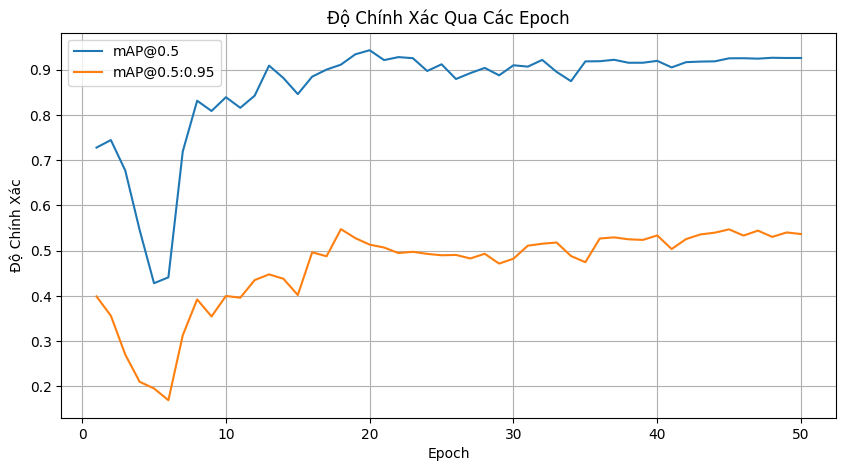

In [15]:
from ultralytics import YOLO

# Tải mô hình
model = YOLO('yolov8s.pt')  # Đảm bảo bạn có đường dẫn mô hình chính xác

# Đào tạo mô hình
model.train(
    data= r'C:\Users\admin\OneDrive\Documents\GitHub\Test\Internship-Aimesoft-ALPR\ALPR\datasets_test.yaml',
    epochs=50,
    batch=8,
    device='cpu',
    imgsz=320,
    cache=True
)

import pandas as pd
import matplotlib.pyplot as plt

log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_string)

results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()

epochs = results.index + 1
mAP_0_5 = results['metrics/mAP50(B)']
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']

plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Độ Chính Xác')
plt.title('Độ Chính Xác Qua Các Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Lưu mô hình
model.save('best_license_plate_model_test.pt')



image 1/1 C:\Users\admin\OneDrive\Documents\GitHub\Test\Internship-Aimesoft-ALPR\ALPR\datasets\cars_license_plate_new\test\images\Cars77.png: 224x320 1 license_plate, 82.0ms
Speed: 3.4ms preprocess, 82.0ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Detected text: HR 26CU6799


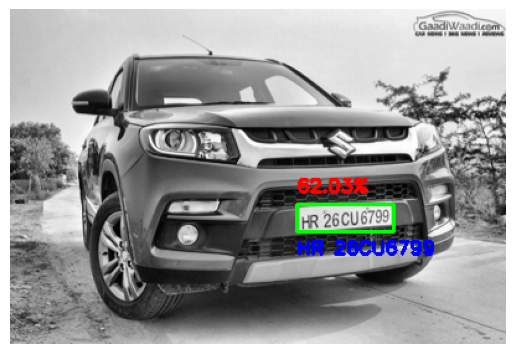

In [17]:
def predict_and_plot(path_test_car):
    results = model.predict(path_test_car, device='cpu')

    image = cv2.imread(path_test_car)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    reader = easyocr.Reader(['en']) 

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            roi = gray_image[y1:y2, x1:x2]

            text = reader.readtext(roi)
            if len(text) > 0:
                text = text[0][1]
            cv2.putText(image, f'{text}', (x1, y1 + 40), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2) 
            print(f"Detected text: {text}")

    plt.imshow(image)
    plt.axis('off')
    plt.show()

predict_and_plot(r'C:\Users\admin\OneDrive\Documents\GitHub\Test\Internship-Aimesoft-ALPR\ALPR\datasets\cars_license_plate_new\test\images\Cars77.png')
